# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

In this exercise you will:

- implement a **loss function** for the Softmax classifier
- implement the  expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
from in5400.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The code uses a traning set, validation set, test set. The small development set is not not necessarily used)

In [17]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'in5400/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data to use the split the training data into a training and a validation subset
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **in5400/classifiers/softmax.py**. 
The softmax response for one sample is 
$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in}$
Please see lecture notes for more robust implementation

You should sum over all samples


#### Note: the functions have the option for including a L2-regularization on the weights, but we will not use (or implement this) now, as this is covered later in the course

In [40]:
# First implement the naive softmax loss function with nested loops.
# Open the file in5400/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from in5400.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.358431
sanity check: 2.302585


## Inline Question 1:

To answer inline questions: double click on this cell and you will be able to edit it. Fill in your text answer below.

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Crossentropy of softmax output as classification loss based on a linear combination of random (untrained) weights should high, since no weight optimization was performed. Correpondingly, estimated likelihood of correctly predicted class (0.1) is low.


# Implement the cross entropy cost 

Compute the gradient of the loss function. 

In [56]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool. We talk about gradient checking on in a later lecture. It is pre-implemented. 
# The numeric gradient should be close to the analytic gradient.
from in5400.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)



numerical: -1.517074 analytic: -1.517074, relative error: 1.319478e-08
numerical: 1.688449 analytic: 1.688449, relative error: 1.683911e-08
numerical: 2.900747 analytic: 2.900746, relative error: 1.763398e-08
numerical: 3.491541 analytic: 3.491541, relative error: 1.112371e-08
numerical: 2.621361 analytic: 2.621361, relative error: 2.352891e-08
numerical: 2.165982 analytic: 2.165982, relative error: 3.006754e-08
numerical: 1.279138 analytic: 1.279138, relative error: 2.484019e-08
numerical: 2.031201 analytic: 2.031201, relative error: 4.062302e-08
numerical: -1.181641 analytic: -1.181641, relative error: 1.624589e-08
numerical: -3.348090 analytic: -3.348090, relative error: 1.697910e-09


Since the numbers are small, the gradient are also small, and your difference should also be very small, arbound e-07 or smaller

In [68]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.0)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from in5400.classifiers.softmax import softmax_loss_vectorized

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.358431e+00 computed in 0.340368s
vectorized loss: 2.358431e+00 computed in 0.018623s
Loss difference: 0.000000
Gradient difference: 0.000000


The difference in loss should be smaller than 0.1, and the gradient difference close to 0. 


In [69]:
# Use the validation set to tune the learning rate. You should experiment with different ranges for the learning
# rates; 
#Note: we do not use regularization yet

from in5400.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
best_lr = -1
#Try with different ranges of learning rate, but smaller than 0.001 
learning_rates = [1e-7, 5e-7]




################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in np.linspace(learning_rates[0], learning_rates[1], 5):
        reg=0
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, num_iters=1000, verbose=True)        
        y_train_acc = (softmax.predict(X_train) == y_train).mean()
        y_val_acc = (softmax.predict(X_val) == y_val).mean()
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax
            best_lr = lr
            
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#print(results.shape)
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('train accuracy, validation accuracy,',results[lr])
    #print('lr %e  train accuracy: %f val accuracy: %f' % (
    #            lr,  train_accuracy, val_accuracy))
    
print('Best learning rate:',best_lr,' best accuracy:',best_val)


iteration 0 / 1000: loss 5.241384
iteration 100 / 1000: loss 3.780679
iteration 200 / 1000: loss 3.372384
iteration 300 / 1000: loss 3.187387
iteration 400 / 1000: loss 2.811622
iteration 500 / 1000: loss 3.061829
iteration 600 / 1000: loss 3.115278
iteration 700 / 1000: loss 2.900617
iteration 800 / 1000: loss 2.789511
iteration 900 / 1000: loss 2.887762
iteration 0 / 1000: loss 5.485234
iteration 100 / 1000: loss 3.493555
iteration 200 / 1000: loss 2.982647
iteration 300 / 1000: loss 2.930490
iteration 400 / 1000: loss 2.751773
iteration 500 / 1000: loss 2.853420
iteration 600 / 1000: loss 2.654423
iteration 700 / 1000: loss 2.640920
iteration 800 / 1000: loss 2.394223
iteration 900 / 1000: loss 2.473253
iteration 0 / 1000: loss 5.549845
iteration 100 / 1000: loss 3.165144
iteration 200 / 1000: loss 3.022435
iteration 300 / 1000: loss 2.880386
iteration 400 / 1000: loss 2.622177
iteration 500 / 1000: loss 2.694437
iteration 600 / 1000: loss 2.621899
iteration 700 / 1000: loss 2.65256

In [74]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.286000


Check your accuracy, you should get at least 0.30 

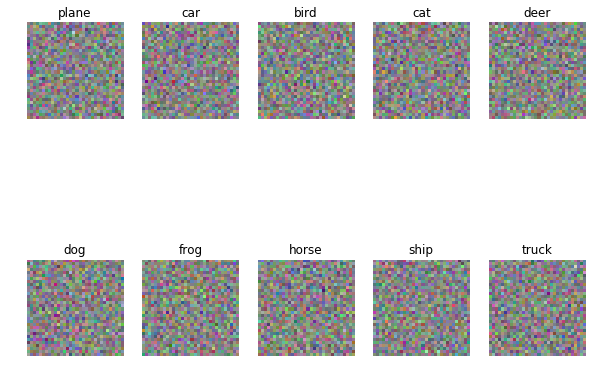

In [75]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])